# Merge NWS Heat Risk and CDC Heat and Health Index w/ H3

In [1]:
# derived from https://github.com/uber/h3-py-notebooks/blob/master/notebooks/unified_data_layers.ipynb

In [2]:
import os
import requests
import zipfile

import numpy as np
import pandas as pd
import geopandas as gpd
import rasterio
from rasterio.features import shapes
from pyproj import CRS

import folium
import matplotlib.pyplot as plt
from IPython.display import display


In [3]:
# import
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import shapely
import rtree
import geopandas
import xarray as xr
from geopandas import GeoDataFrame
from shapely.geometry import mapping
from shapely.ops import cascaded_union#, unary_union
import h3
import base64
import urllib
import tempfile
# import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

#Functions
def plot_scatter(df, metric_col, x='lng', y='lat', marker='.', alpha=1, figsize=(16,12), colormap='viridis'):    
    df.plot.scatter(x=x, y=y, c=metric_col, title=metric_col
                    , edgecolors='none', colormap=colormap, marker=marker, alpha=alpha, figsize=figsize);
    plt.xticks([], []); plt.yticks([], [])

def aperture_downsampling(df, hex_col, metric_col, coarse_aperture_size):
    df_coarse = df.copy()
    coarse_hex_col = 'hex{}'.format(coarse_aperture_size)
    df_coarse[coarse_hex_col] = df_coarse[hex_col].apply(lambda x: h3.h3_to_parent(x,coarse_aperture_size))
    dfc = df_coarse.groupby([coarse_hex_col])[[metric_col,]].mean().reset_index()
    dfc['lat'] = dfc[coarse_hex_col].apply(lambda x: h3.h3_to_geo(x)[0])
    dfc['lng'] = dfc[coarse_hex_col].apply(lambda x: h3.h3_to_geo(x)[1]) 
    return dfc

def kring_smoothing(df, hex_col, metric_col, k):
    dfk = df[[hex_col]] 
    dfk.index = dfk[hex_col]
    dfs =  (dfk[hex_col]
                 .apply(lambda x: pd.Series(list(h3.k_ring(x,k)))).stack()
                 .to_frame('hexk').reset_index(1, drop=True).reset_index()
                 .merge(df[[hex_col,metric_col]]).fillna(0)
                 .groupby(['hexk'])[[metric_col]].sum().divide((1 + 3 * k * (k + 1)))
                 .reset_index()
                 .rename(index=str, columns={"hexk": hex_col}))
    dfs['lat'] = dfs[hex_col].apply(lambda x: h3.h3_to_geo(x)[0])
    dfs['lng'] = dfs[hex_col].apply(lambda x: h3.h3_to_geo(x)[1]) 
    return dfs

def weighted_kring_smoothing(df, hex_col, metric_col, coef):
    # normalize the coef
    a = []
    for k, coe in enumerate(coef):
        if k == 0:
            a.append(coe)
        else:
            a.append(k * 6 * coe)
    coef = [c / sum(a) for c in coef]
    
    # weighted smoothing 
    df_agg = df[[hex_col]]
    df_agg['hexk'] = df_agg[hex_col]
    df_agg.set_index(hex_col,inplace=True)
    temp2 = [df_agg['hexk'].reset_index()]
    temp2[-1]['k'] = 0
    K=len(coef)-1 
    for k in range(1,K+1):
        temp2.append((df_agg['hexk']
                     .apply(lambda x: pd.Series(list(h3.hex_ring(x,k)))).stack()
                     .to_frame('hexk').reset_index(1, drop=True).reset_index()
                ))
        temp2[-1]['k'] = k
    df_all = pd.concat(temp2).merge(df)
    df_all[metric_col] = df_all[metric_col]*df_all.k.apply(lambda x:coef[x])
    dfs = df_all.groupby('hexk')[[metric_col]].sum().reset_index().rename(index=str, columns={"hexk": hex_col})
    dfs['lat'] = dfs[hex_col].apply(lambda x: h3.h3_to_geo(x)[0])
    dfs['lng'] = dfs[hex_col].apply(lambda x: h3.h3_to_geo(x)[1])
    return dfs

## fetch data and merge CDC Heat and Health Index Data + US Census ZCTA Map

In [4]:
data_dir = "data"

boundaries_file = f"../{data_dir}/cb_2020_us_zcta520_500k.shp"
zcta_boundaries = gpd.read_file(boundaries_file).to_crs(epsg=4326)

parquet_file = f"../{data_dir}/HHI Data 2024 United States.parquet"
hhi_data = pd.read_parquet(parquet_file)

In [5]:
hhi_data['ZCTA'] = hhi_data['ZCTA'].astype(str)
zcta_boundaries['ZCTA5CE20'] = zcta_boundaries['ZCTA5CE20'].astype(str)
zcta_with_hhi = zcta_boundaries.merge(hhi_data, left_on='ZCTA5CE20', right_on='ZCTA', how='inner')

<Axes: >

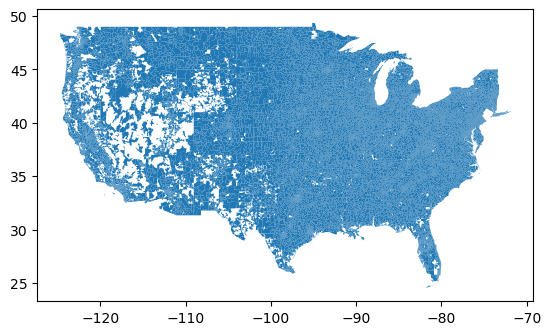

In [6]:
zcta_with_hhi.plot()

## convert ZCTA polygon to hex

In [7]:
APERTURE_SIZE = 10 
# Unify the CT boundries
union_poly = cascaded_union(zcta_with_hhi.geometry)

# Find the hexs within the city boundary using PolyFill
hex_list=[]
for n,g in enumerate(union_poly):
    print(n,'\r')
    temp  = mapping(g)
    temp['coordinates']=[[[j[1],j[0]] for j in i] for i in temp['coordinates']]  
    hex_list.extend(h3.polyfill(temp,APERTURE_SIZE))

# create hex dataframe
hex_col = 'hex{}'.format(APERTURE_SIZE)
dfh = pd.DataFrame(hex_list,columns=[hex_col])
print('Sanity Check\nnumber of hexes:', len(hex_list))
print('number of duplicates:', len(hex_list) - len(dfh.drop_duplicates()))

# add lat & lng of center of hex 
dfh['lat']=dfh[hex_col].apply(lambda x: h3.h3_to_geo(x)[0])
dfh['lng']=dfh[hex_col].apply(lambda x: h3.h3_to_geo(x)[1])

# create Point object based on hex latlng
dfh['geometry'] = dfh.apply(lambda x: shapely.geometry.Point(x.lng,x.lat),1)
dfh.crs = {"init": "epsg:4326"}

# plot hex latlng
dfh.plot(x='lng',y='lat',style='.',alpha=.1,figsize=(12,12));
plt.title('hex-grid: nyc')
dfh = GeoDataFrame(dfh)
# Intersect Hex Point with CT Polygon
df_ct = geopandas.tools.sjoin(gdf, dfh, how="inner")
df_ct.sample(3)

TypeError: 'MultiPolygon' object is not iterable